In [2]:
import sqlite3
from faker import Faker
import random
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
fake = Faker()

with open('DDL.sql', 'r', encoding='utf-8') as f:
    SCHEMA_SQL = f.read()

In [7]:
# Функция для генерации случайной даты
def random_date(start_date, end_date):
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    return start_date + timedelta(days=random_days)

# Генерация данных
customers = []
accounts = []
loan_products = []
loans = []
transactions = []

# 50 клиентов
for i in range(1, 51):
    sex = random.choice(['M', 'F'])
    customers.append((
        i,
        fake.first_name_male() if sex == 'M' else fake.first_name_female(),
        fake.last_name(),
        fake.phone_number()[:15],
        sex,
        random_date(datetime(1960, 1, 1), datetime(2005, 12, 31)).strftime('%Y-%m-%d')
    ))

# 100 счетов
account_types = ['Savings', 'Checking', 'Investment']
currencies = ['USD', 'EUR', 'GBP']
for i in range(1, 101):
    accounts.append((
        i,
        random.randint(1, 50),
        random.choice(account_types),
        round(random.uniform(100.00, 50000.00), 2),
        random.choice(currencies)
    ))

# 5 кредитных продуктов
loan_product_names = ['Personal Loan', 'Car Loan', 'Home Loan', 'Education Loan', 'Business Loan']
for i in range(1, 6):
    valid_to = random_date(datetime(2025, 1, 1), datetime(2030, 12, 31)) if random.choice([True, False]) else None
    loan_products.append((
        i,
        loan_product_names[i-1],
        round(random.uniform(3.0, 10.0), 2),
        round(random.uniform(5000.00, 100000.00), 2),
        1 if random.choice([True, False]) else 0,
        random_date(datetime(2020, 1, 1), datetime(2023, 12, 31)).strftime('%Y-%m-%d'),
        valid_to.strftime('%Y-%m-%d') if valid_to else None
    ))

# 30 кредитов
for i in range(1, 31):
    account_id = random.randint(1, 100)
    customer_id = accounts[account_id-1][1]
    loans.append((
        i,
        customer_id,
        account_id,
        random.randint(1, 5),
        round(random.uniform(1000.00, 50000.00), 2),
        random_date(datetime(2023, 1, 1), datetime(2025, 5, 12)).strftime('%Y-%m-%d')
    ))

# 200 транзакций
for i in range(1, 201):
    sender_id = random.randint(1, 100)
    type_of_target = random.choice(['account', 'loan'])
    target_account_id = random.randint(1, 100) if type_of_target == 'account' else None
    target_loan_id = random.randint(1, 30) if type_of_target == 'loan' else None
    transactions.append((
        i,
        sender_id,
        type_of_target,
        target_account_id,
        target_loan_id,
        random_date(datetime(2023, 1, 1), datetime(2025, 5, 12)).strftime('%Y-%m-%d'),
        round(random.uniform(50.00, 10000.00), 2)
    ))

# Формирование SQL-команд для вставки
INSERT_SQL = """
INSERT INTO Customers (customer_id, first_name, last_name, phone_number, sex, date_of_birth) VALUES
""" + ",\n".join([f"({c[0]}, '{c[1]}', '{c[2]}', '{c[3]}', '{c[4]}', '{c[5]}')" for c in customers]) + ";\n\n" + \
"""
INSERT INTO Accounts (account_id, customer_id, account_type, balance, currency) VALUES
""" + ",\n".join([f"({a[0]}, {a[1]}, '{a[2]}', {a[3]}, '{a[4]}')" for a in accounts]) + ";\n\n" + \
"""
INSERT INTO LoanProducts (product_id, product_name, interest_rate, max_loan_amount, is_active, valid_from, valid_to) VALUES
""" + ",\n".join([f"({lp[0]}, '{lp[1]}', {lp[2]}, {lp[3]}, {lp[4]}, '{lp[5]}', {f'\"{lp[6]}\"' if lp[6] else 'NULL'})" for lp in loan_products]) + ";\n\n" + \
"""
INSERT INTO Loans (loan_id, customer_id, account_id, product_id, loan_amount, start_date) VALUES
""" + ",\n".join([f"({l[0]}, {l[1]}, {l[2]}, {l[3]}, {l[4]}, '{l[5]}')" for l in loans]) + ";\n\n" + \
"""
INSERT INTO Transactions (transaction_id, sender_id, type_of_target, target_account_id, target_loan_id, transaction_date, amount) VALUES
""" + ",\n".join([f"({t[0]}, {t[1]}, '{t[2]}', {t[3] if t[3] else 'NULL'}, {t[4] if t[4] else 'NULL'}, '{t[5]}', {t[6]})" for t in transactions]) + ";"

# Сохранение INSERT_SQL в файл
with open('inserts_generated.sql', 'w', encoding='utf-8') as f:
    f.write(INSERT_SQL)

# Подключение к базе и вставка данных
conn = sqlite3.connect(':memory:')
conn.execute("PRAGMA foreign_keys = ON;")
conn.executescript(SCHEMA_SQL)
conn.executescript(INSERT_SQL)
conn.commit()

In [8]:
exchange_rates = {
    'usd': 1.0,
    'eur': 1.2,
    'gbp': 1.4
}

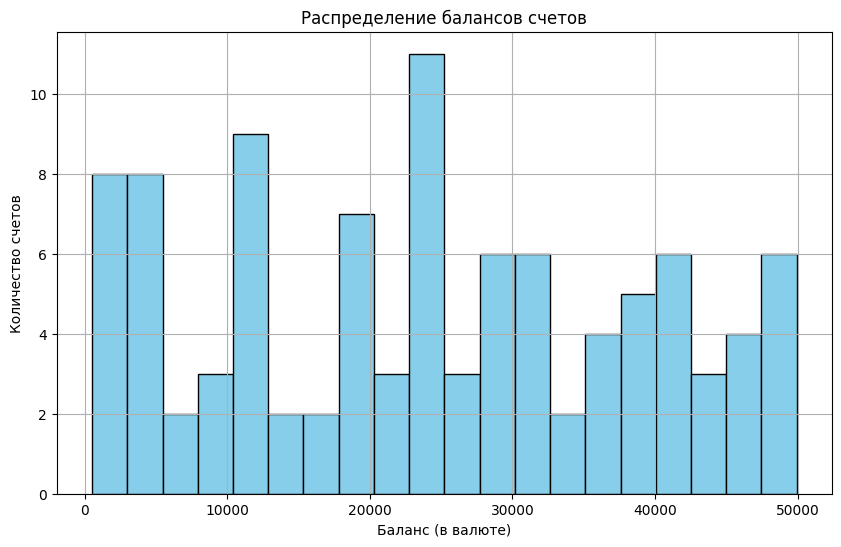

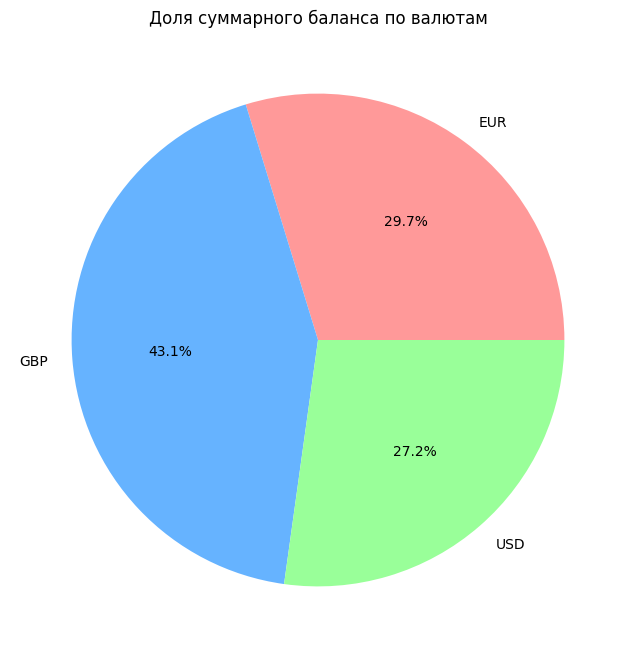

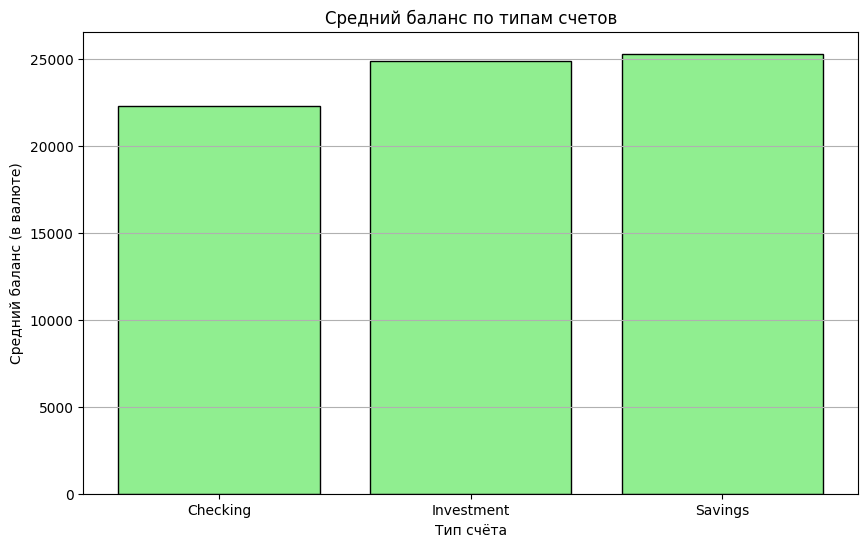


Суммарный баланс по валютам:
  currency  total_balance  total_balance_usd
0      EUR      719937.49         863924.988
1      GBP     1042566.38        1459592.932
2      USD      658516.09         658516.090

Средний баланс по типам счетов:
  account_type   avg_balance
0     Checking  22256.040968
1   Investment  24871.311515
2      Savings  25286.928056

Первые 5 балансов для гистограммы:
    balance
0  32247.15
1  30890.43
2  36905.92
3  10172.62
4   3004.98


In [9]:
# Извлечение данных
# 1. Суммарный баланс по валютам
cursor = conn.execute("""
SELECT currency, SUM(balance) as total_balance
FROM Accounts
GROUP BY currency;
""")
currency_balances = pd.DataFrame(cursor.fetchall(), columns=['currency', 'total_balance'])
currency_balances['total_balance_usd'] = currency_balances.apply(
    lambda row: row['total_balance'] * exchange_rates[row['currency'].lower()],
    axis=1
)

# 2. Средний баланс по типам счетов
cursor = conn.execute("""
SELECT account_type, AVG(balance) as avg_balance
FROM Accounts
GROUP BY account_type;
""")
account_type_balances = pd.DataFrame(cursor.fetchall(), columns=['account_type', 'avg_balance'])

# 3. Все балансы для гистограммы
cursor = conn.execute("SELECT balance FROM Accounts;")
all_balances = pd.DataFrame(cursor.fetchall(), columns=['balance'])

# Закрытие соединения
conn.close()

# Построение графиков

# 1. Гистограмма распределения балансов
plt.figure(figsize=(10, 6))
plt.hist(all_balances['balance'], bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение балансов счетов')
plt.xlabel('Баланс (в валюте)')
plt.ylabel('Количество счетов')
plt.grid(True)
#plt.savefig('balance_histogram.png')
plt.show()

# 2. Круговая диаграмма доли балансов по валютам
plt.figure(figsize=(8, 8))
plt.pie(currency_balances['total_balance'], labels=currency_balances['currency'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Доля суммарного баланса по валютам')
#plt.savefig('currency_pie_chart.png')
plt.show()

# 3. Столбчатая диаграмма среднего баланса по типам счетов
plt.figure(figsize=(10, 6))
plt.bar(account_type_balances['account_type'], account_type_balances['avg_balance'], color='lightgreen', edgecolor='black')
plt.title('Средний баланс по типам счетов')
plt.xlabel('Тип счёта')
plt.ylabel('Средний баланс (в валюте)')
plt.grid(True, axis='y')
#plt.savefig('account_type_bar_chart.png')
plt.show()

# Вывод результатов
print("\nСуммарный баланс по валютам:")
print(currency_balances)
print("\nСредний баланс по типам счетов:")
print(account_type_balances)
print("\nПервые 5 балансов для гистограммы:")
print(all_balances.head())